<img src="https://i.imgur.com/af0uuSN.png">
<h1><center>🩺OSIC Pulmonary Fibrosis Competition🩺</center></h1>
<h2><center>EDA and Preprocessing</center></h2>

# 1. Introduction

### #1. Why do we do this?

> **Pulmonary = lung | fibrosis = scar tissue => Scarring in the lungs.** Over time, scarring can destroy the normal lung and make it hard for oxygen to get into your blood. [Pulmonary fibrosis isn’t just one disease. It is a family of more than 200 different lung diseases that all look very much alike.](https://www.pulmonaryfibrosis.org/life-with-pf/about-pf)

<img src="https://www.pulmonaryfibrosis.org/images/default-source/default-album/normal-and-impaired-gas-exchange.png?sfvrsn=c3b0918d_0" width=600>

### #2. Evaluation

**Laplace Log Likelihood (modified version)**: useful to evaluate a model's confidence in its decisions.

The error is thresholded at 1000 ml to avoid large errors adversely penalizing results, while the confidence values are clipped at 70 ml to reflect the approximate measurement uncertainty in FVC. The final score is calculated by averaging the metric across all test set Patient_Weeks (three per patient). 

*Note that metric values will be negative and higher is better.*

### #3. Code Competition

Code Competitions seem more fair to me. Keep in mind:
* CPU runtime <= 9 hrs
* GPU runtime <= 4 hrs
* NO internet access (for inference, but can be used during training)
* Submission file name: `submission.csv`

### #4. Competition aim:
> Predict how severe is going to decline the lung capacity in the lungs based on a CT (Computerised Tomography) scan + metadata of the patient. CTs can show soft tissues, blood vessels, and bones much more detailed than normal X-rays.

**Lung Function**: assessed based on a spirometer output which measures the FVC (forced vital capacity), meaning how much air is exhaled.


### Libraries 📚⬇

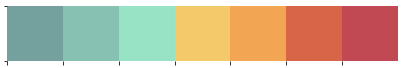

In [1]:
# Regular Imports
import os #to interact with the system folders
import pandas as pd #for handling dataframes
import numpy as np #for handling arrays
import seaborn as sns #for visualization
import matplotlib.pyplot as plt #for visualization
%matplotlib inline
import matplotlib.image as mpimg #for visualizing image
from tabulate import tabulate #to print tabular data in a nicely fomatted way
import missingno as msno  #missing data visualization module
from IPython.display import display_html #to display html code
from PIL import Image #image processing
import gc #optimal garbaage collector library
import cv2 #open computer vision
from scipy.stats import pearsonr #pearson correlation 

import pydicom # for DICOM images
from skimage.transform import resize #manupulating image pixel
import copy
import re #regular expression

# Segmentation
from glob import glob #used to search for files that match a specific file pattern or name
from mpl_toolkits.mplot3d.art3d import Poly3DCollection #plot the transparent images
import scipy.ndimage 
from skimage import morphology 
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

import warnings
warnings.filterwarnings("ignore")


# Set Color Palettes for the notebook
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

In [2]:
plt.rc('xtick',labelsize=11)
plt.rc('ytick',labelsize=11)

# 2. The Metadata 🗄

### We need to predict:
* FVC - final 3 values for each patient (only these will be used for the final score)
* Confidence Value - [a thread about what it is here](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/166753). It is measured in ml and it's "how confident" are you about the the estimated FVC. High value in confidence means that you are off a lot from the actual FVC, while a very low (or even 0) confidence means you're very sure on the FVC. (if somebody thinks this is not correct, please text me, I might be wrong about this)

> <img src="https://i.imgur.com/8AWVnqQ.png" width=650>

In [3]:
# Import train + test data
train = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/train.csv")
test = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/test.csv")

# Train len
print("Total Recordings in Train Data: {:,}".format(len(train)))

Total Recordings in Train Data: 1,549


In [4]:
df1_styler = train.head().style.set_table_attributes("style='display:inline'").set_caption('Head Train Data')
df2_styler = test.style.set_table_attributes("style='display:inline'").set_caption('Test Data (rest Hidden)')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

Head Train Data Patient Weeks FVC Percent Age Sex SmokingStatus 
 
 0 
 ID00007637202177411956430 
 -4 
 2315 
 58.253649 
 79 
 Male 
 Ex-smoker 
 
 
 1 
 ID00007637202177411956430 
 5 
 2214 
 55.712129 
 79 
 Male 
 Ex-smoker 
 
 
 2 
 ID00007637202177411956430 
 7 
 2061 
 51.862104 
 79 
 Male 
 Ex-smoker 
 
 
 3 
 ID00007637202177411956430 
 9 
 2144 
 53.950679 
 79 
 Male 
 Ex-smoker 
 
 
 4 
 ID00007637202177411956430 
 11 
 2069 
 52.063412 
 79 
 Male 
 Ex-smoker 
 
 Test Data (rest Hidden) Patient Weeks FVC Percent Age Sex SmokingStatus 
 
 0 
 ID00419637202311204720264 
 6 
 3020 
 70.186855 
 73 
 Male 
 Ex-smoker 
 
 
 1 
 ID00421637202311550012437 
 15 
 2739 
 82.045291 
 68 
 Male 
 Ex-smoker 
 
 
 2 
 ID00422637202311677017371 
 6 
 1930 
 76.672493 
 73 
 Male 
 Ex-smoker 
 
 
 3 
 ID00423637202312137826377 
 17 
 3294 
 79.258903 
 72 
 Male 
 Ex-smoker 
 
 
 4 
 ID00426637202313170790466 
 0 
 2925 
 71.824968 
 73 
 Male 
 Never smoked

## #2.1 Any Missing Values? (❔)

> **📌Remember**: No missing values ^^

In [5]:
print("Q: Are there any missing values?", "\n" +
      "A: {}".format(train.isnull().values.any()))

Q: Are there any missing values? 
A: False


## #2.2 How Many unique patients? 👩‍⚕️👨‍⚕️

> **📌Remember**: **176** unique patients, with entries between 6 and 10 each.

There are 176 unique patients in Train Data. 

Minimum number of entries are: 6 
Maximum number of entries are: 10


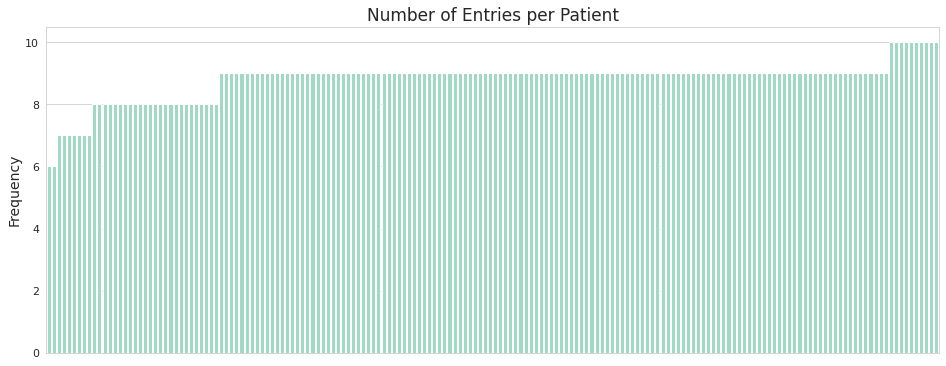

In [6]:
print("There are {} unique patients in Train Data.".format(len(train["Patient"].unique())), "\n")

# Recordings per Patient
data = train.groupby(by="Patient")["Weeks"].count().reset_index(drop=False)
# Sort by Weeks
data = data.sort_values(['Weeks']).reset_index(drop=True)
print("Minimum number of entries are: {}".format(data["Weeks"].min()), "\n" +
      "Maximum number of entries are: {}".format(data["Weeks"].max()))

# Plot
plt.figure(figsize = (16, 6))
p = sns.barplot(data["Patient"], data["Weeks"], color=custom_colors[2])

plt.title("Number of Entries per Patient", fontsize = 17)
plt.xlabel('Patient', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

p.axes.get_xaxis().set_visible(False);

## #2.3 Patients Bio: who are they? 🤷‍♂️

> **📌Remember**: 
1. **Age**: As the competition description mentions, patients have between 50 and 90 years old, with the majority being between 60 and 70 yo.
2. **Gender**: The vast majority of the patients are Males.
3. **Smoking Status**: The vast majority are Ex-smokers. ~50 never smoked and less than 10 patients are still smoking.

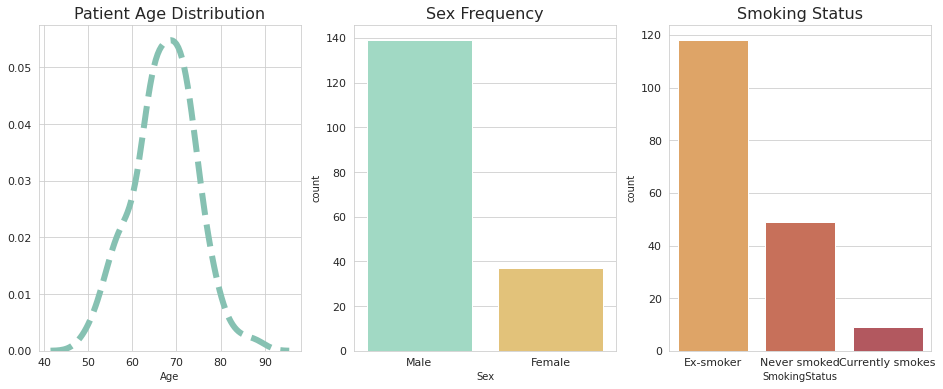

In [7]:
# Select unique bio info for the patients
data = train.groupby(by="Patient")[["Patient", "Age", "Sex", "SmokingStatus"]].first().reset_index(drop=True)

# Figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 6))

a = sns.distplot(data["Age"], ax=ax1, color=custom_colors[1], hist=False, kde_kws=dict(lw=6, ls="--"))
b = sns.countplot(data["Sex"], ax=ax2, palette=custom_colors[2:4])
c = sns.countplot(data["SmokingStatus"], ax=ax3, palette = custom_colors[4:7])

a.set_title("Patient Age Distribution", fontsize=16)
b.set_title("Sex Frequency", fontsize=16)
c.set_title("Smoking Status", fontsize=16);

## #2.4 FVC & Percent ⚖

<div class="alert alert-block alert-info">
<p><b>FVC</b> the recorded lung capacity in ml (how much air you can exhale in a maximal forced expiration effort)</p>
<p><b>Percent</b> a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics</p>
</div>

> **📌Remember**: 
1. **FVC**: most values lie between 1,000 and 5,000 ml. There are also some very high outliers above 5,000 and little values that lie below 1,000.
2. **Percent**: more than ~80% of the patients scored below 100%.

Min FVC value: 827 
Max FVC value: 6,399 

Min Percent value: 28.88% 
Max Percent value: 153.1%


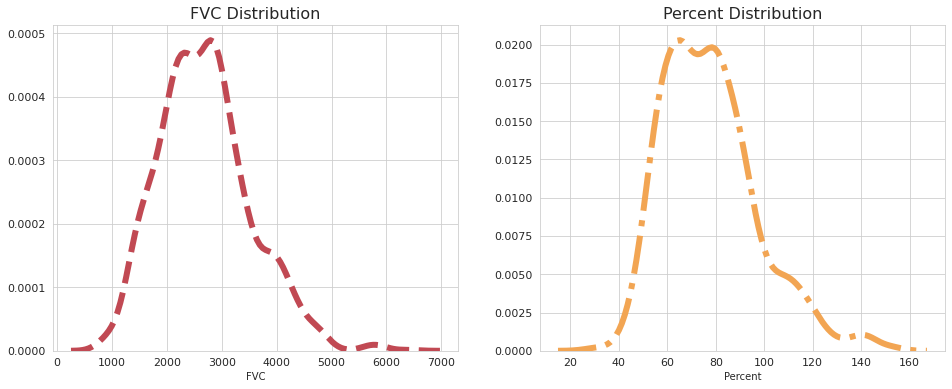

In [8]:
print("Min FVC value: {:,}".format(train["FVC"].min()), "\n" +
      "Max FVC value: {:,}".format(train["FVC"].max()), "\n" +
      "\n" +
      "Min Percent value: {:.4}%".format(train["Percent"].min()), "\n" +
      "Max Percent value: {:.4}%".format(train["Percent"].max()))

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.distplot(train["FVC"], ax=ax1, color=custom_colors[6], hist=False, kde_kws=dict(lw=6, ls="--"))
b = sns.distplot(train["Percent"], ax=ax2, color=custom_colors[4], hist=False, kde_kws=dict(lw=6, ls="-."))

a.set_title("FVC Distribution", fontsize=16)
b.set_title("Percent Distribution", fontsize=16);

## #2.5 Weeks📅

> `Weeks`: the relative number of weeks pre/post the baseline CT (may be negative)

Minimum no. weeks before CT: -5 
Maximum no. weeks after CT: 133


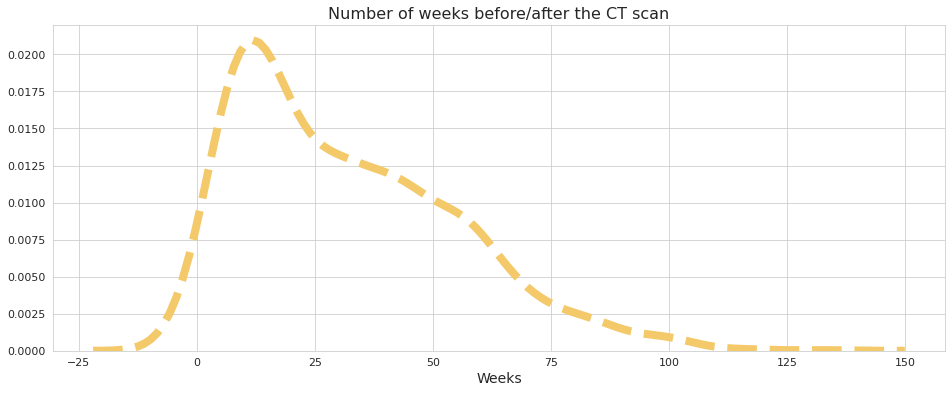

In [9]:
print("Minimum no. weeks before CT: {}".format(train['Weeks'].min()), "\n" +
      "Maximum no. weeks after CT: {}".format(train['Weeks'].max()))

plt.figure(figsize = (16, 6))

a = sns.distplot(train['Weeks'], color=custom_colors[3], hist=False, kde_kws=dict(lw=8, ls="--"))
plt.title("Number of weeks before/after the CT scan", fontsize = 16)
plt.xlabel("Weeks", fontsize=14);

## #2.6 Correlations between Variables🧬

> **📌Remember**: 
* There is high correlation between FVC and Percent: when the volume of air increases, the Percent increases as well (when you exhale more, you get closer more to 100%)
* There is no correlation between FVC/Percent and Age, meaning that Age has no influence on the volume of exhaled air.

Pearson Corr FVC x Percent: 0.672 
Pearson Corr FVC x Age: -0.09 
Pearson Corr Percent x Age: 0.096


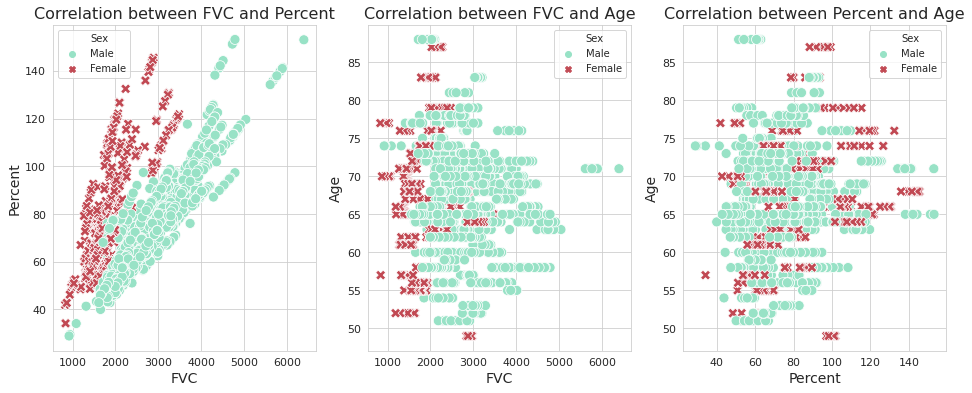

In [10]:
# Compute Correlation
corr1, _ = pearsonr(train["FVC"], train["Percent"])
corr2, _ = pearsonr(train["FVC"], train["Age"])
corr3, _ = pearsonr(train["Percent"], train["Age"])
print("Pearson Corr FVC x Percent: {:.4}".format(corr1), "\n" +
      "Pearson Corr FVC x Age: {:.0}".format(corr2), "\n" +
      "Pearson Corr Percent x Age: {:.2}".format(corr3))

# Figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 6))

a = sns.scatterplot(x = train["FVC"], y = train["Percent"], palette=[custom_colors[2], custom_colors[6]],
                    hue = train["Sex"], style = train["Sex"], s=100, ax=ax1)

b = sns.scatterplot(x = train["FVC"], y = train["Age"], palette=[custom_colors[2], custom_colors[6]],
                    hue = train["Sex"], style = train["Sex"], s=100, ax=ax2)

c = sns.scatterplot(x = train["Percent"], y = train["Age"], palette=[custom_colors[2], custom_colors[6]],
                    hue = train["Sex"], style = train["Sex"], s=100, ax=ax3)

a.set_title("Correlation between FVC and Percent", fontsize = 16)
a.set_xlabel("FVC", fontsize = 14)
a.set_ylabel("Percent", fontsize = 14)

b.set_title("Correlation between FVC and Age", fontsize = 16)
b.set_xlabel("FVC", fontsize = 14)
b.set_ylabel("Age", fontsize = 14)

c.set_title("Correlation between Percent and Age", fontsize = 16)
c.set_xlabel("Percent", fontsize = 14)
c.set_ylabel("Age", fontsize = 14);

> This is VERY weird: FVC and Percent are the highest for people that still smoke and the lowest for people that never smoked. HOWEVER, we need to keep in mind that the percentage of people that still smoke is very low. So, we CAN'T conclude that if a person smokes it's highly likely that will have a high FVC.

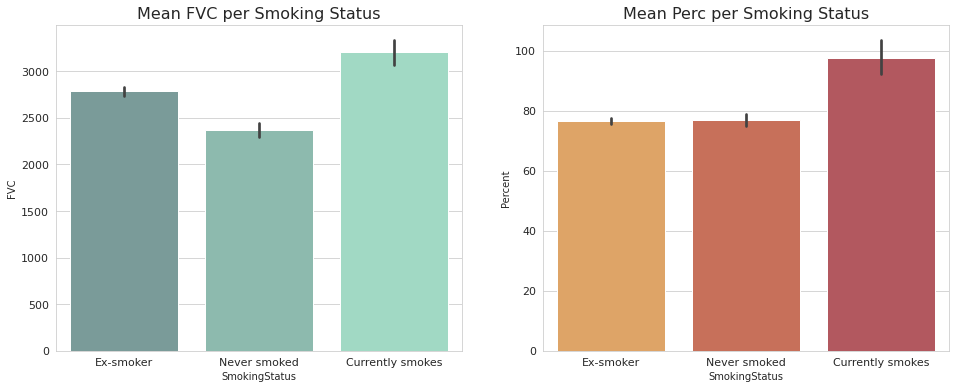

In [11]:
# Figure
f, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 6))

a = sns.barplot(x = train["SmokingStatus"], y = train["FVC"], ax=ax1, palette=custom_colors[0:4])
b = sns.barplot(x = train["SmokingStatus"], y = train["Percent"], ax=ax2, palette=custom_colors[4:7])

a.set_title("Mean FVC per Smoking Status", fontsize=16)
b.set_title("Mean Perc per Smoking Status", fontsize=16);

## #2.7 Evolution of FVC in Patients 📉

In [12]:
# Create Time variable to count in ascending order the times the Patient has done a check in FVC
data_time = train.groupby(by="Patient")["Weeks"].count().reset_index()
train["Time"] = 0

for patient, times in zip(data_time["Patient"], data_time["Weeks"]):
    train.loc[train["Patient"] == patient, 'Time'] = range(1, times+1)

In [13]:
# For graph purposes, keep only Patients that had a big difference in FVC between Time 1 and last Time
min_fvc = train[train["Time"] == 1][["Patient", "FVC"]].reset_index(drop=True)

idx = train.groupby(["Patient"])["Weeks"].transform(max) == train["Weeks"]
max_fvc = train[idx][["Patient", "FVC"]].reset_index(drop=True)

# Compute difference and select only top patients with biggest difference
data = pd.merge(min_fvc, max_fvc, how="inner", on="Patient")
data["Dif"] = data["FVC_x"] - data["FVC_y"]

# Select only top n
l = list(data.sort_values("Dif", ascending=False).head(100)["Patient"])
x = train[train["Patient"].isin(l)]

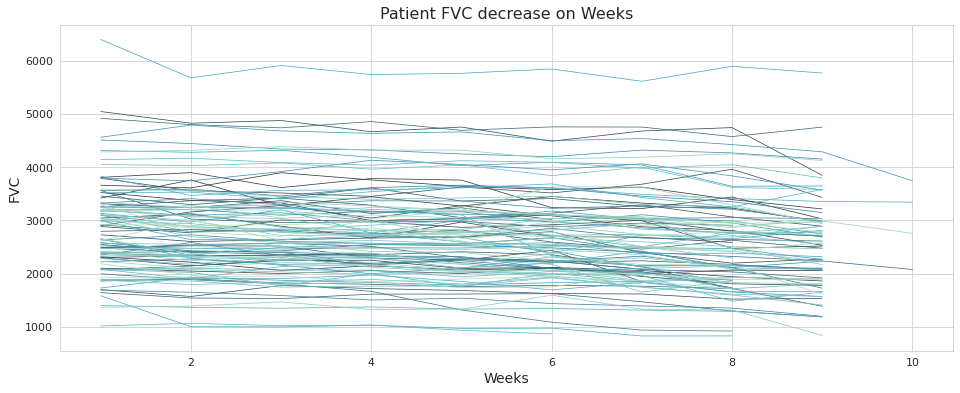

In [14]:
plt.figure(figsize = (16, 6))

a = sns.lineplot(x = x["Time"], y = x["FVC"], hue = x["Patient"], legend=False,
                 palette=sns.color_palette("GnBu_d", 100), size=1)

plt.title("Patient FVC decrease on Weeks", fontsize = 16)
plt.xlabel("Weeks", fontsize=14)
plt.ylabel("FVC", fontsize=14);

# 3. DICOM Data 📸

> [What are CT scans capturing?](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/167085)

> **Dicom Files**: [A DICOM file is an image saved in the Digital Imaging and Communications in Medicine (DICOM) format.](https://fileinfo.com/extension/dicom#:~:text=A%20DICOM%20file%20is%20an,linked%20to%20a%20specific%20individual.)

In [15]:
# Create base director for Train .dcm files
director = "../input/osic-pulmonary-fibrosis-progression/train"

# Create path column with the path to each patient's CT
train["Path"] = director + "/" + train["Patient"]

# Create variable that shows how many CT scans each patient has
train["CT_number"] = 0

for k, path in enumerate(train["Path"]):
    train["CT_number"][k] = len(os.listdir(path))

## 3.1 Number of CT scans per Patient👴

> **📌Remember**: Huge imbalance in the number of CT scans: half of the patients have less that 100 photos registered.

Minimum number of CT scans: 12 
Maximum number of CT scans: 1,018


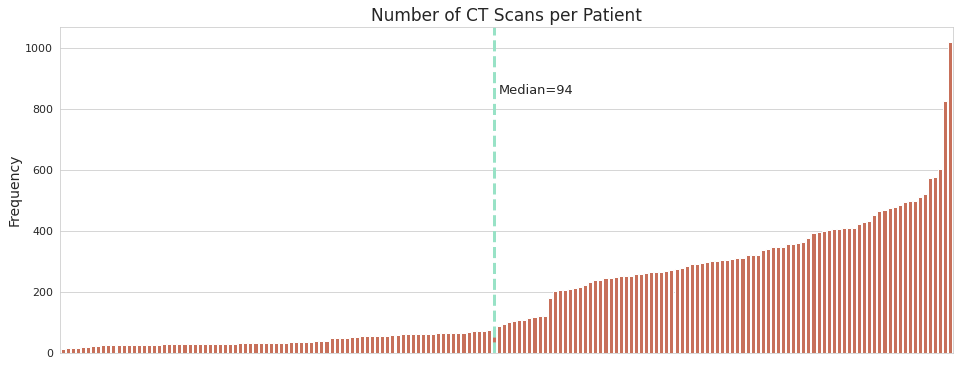

In [16]:
print("Minimum number of CT scans: {}".format(train["CT_number"].min()), "\n" +
      "Maximum number of CT scans: {:,}".format(train["CT_number"].max()))

# Scans per Patient
data = train.groupby(by="Patient")["CT_number"].first().reset_index(drop=False)
# Sort by Weeks
data = data.sort_values(['CT_number']).reset_index(drop=True)

# Plot
plt.figure(figsize = (16, 6))
p = sns.barplot(data["Patient"], data["CT_number"], color=custom_colors[5])
plt.axvline(x=85, color=custom_colors[2], linestyle='--', lw=3)

plt.title("Number of CT Scans per Patient", fontsize = 17)
plt.xlabel('Patient', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.text(86, 850, "Median=94", fontsize=13)

p.axes.get_xaxis().set_visible(False);

## 3.2 Visualise DICOM Info and Image

> DICOM data can be extracted by using `pydicom.dcmread()`

> [What color maps should you use in medical visualisation?](http://noeskasmit.com/colormaps-in-medical-visualization/)

In [17]:
class bcolors:
    OKBLUE = '\033[96m'
    OKGREEN = '\033[92m'

In [18]:
# https://gist.github.com/FedeMiorelli/640bbc66b2038a14802729e609abfe89
# Create Turbo color map
turbo_colormap_data = np.array(
                       [[0.18995,0.07176,0.23217],
                       [0.19483,0.08339,0.26149],
                       [0.19956,0.09498,0.29024],
                       [0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],
                       [0.21291,0.12947,0.37314],
                       [0.21708,0.14087,0.39964],
                       [0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],
                       [0.22875,0.17481,0.47578],
                       [0.23236,0.18603,0.50004],
                       [0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],
                       [0.24234,0.21941,0.56942],
                       [0.24539,0.23044,0.59142],
                       [0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],
                       [0.25369,0.26327,0.65406],
                       [0.25618,0.27412,0.67381],
                       [0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],
                       [0.26280,0.30639,0.72968],
                       [0.26473,0.31706,0.74718],
                       [0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],
                       [0.26967,0.34878,0.79631],
                       [0.27103,0.35926,0.81156],
                       [0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],
                       [0.27429,0.39043,0.85393],
                       [0.27509,0.40072,0.86692],
                       [0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],
                       [0.27667,0.43134,0.90254],
                       [0.27691,0.44145,0.91328],
                       [0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],
                       [0.27680,0.47151,0.94214],
                       [0.27648,0.48144,0.95064],
                       [0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],
                       [0.27469,0.51094,0.97275],
                       [0.27381,0.52069,0.97899],
                       [0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],
                       [0.26878,0.54995,0.99303],
                       [0.26592,0.55979,0.99583],
                       [0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],
                       [0.25425,0.58950,0.99896],
                       [0.24946,0.59943,0.99835],
                       [0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],
                       [0.23288,0.62923,0.99202],
                       [0.22676,0.63913,0.98851],
                       [0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],
                       [0.20708,0.66866,0.97423],
                       [0.20021,0.67842,0.96833],
                       [0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],
                       [0.17923,0.70732,0.94761],
                       [0.17223,0.71680,0.93981],
                       [0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],
                       [0.15173,0.74472,0.91416],
                       [0.14519,0.75381,0.90496],
                       [0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],
                       [0.12698,0.78037,0.87590],
                       [0.12151,0.78896,0.86581],
                       [0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],
                       [0.10738,0.81381,0.83484],
                       [0.10357,0.82177,0.82437],
                       [0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],
                       [0.09532,0.84455,0.79299],
                       [0.09377,0.85175,0.78264],
                       [0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],
                       [0.09320,0.87211,0.75237],
                       [0.09451,0.87844,0.74265],
                       [0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],
                       [0.10342,0.89600,0.71500],
                       [0.10815,0.90142,0.70599],
                       [0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],
                       [0.12733,0.91701,0.67627],
                       [0.13526,0.92197,0.66556],
                       [0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],
                       [0.16319,0.93609,0.63137],
                       [0.17377,0.94053,0.61938],
                       [0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],
                       [0.20877,0.95304,0.58199],
                       [0.22142,0.95692,0.56914],
                       [0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],
                       [0.26180,0.96765,0.52981],
                       [0.27597,0.97092,0.51653],
                       [0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],
                       [0.32006,0.97974,0.47654],
                       [0.33517,0.98234,0.46325],
                       [0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],
                       [0.38127,0.98909,0.42386],
                       [0.39678,0.99098,0.41098],
                       [0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],
                       [0.44321,0.99551,0.37345],
                       [0.45854,0.99663,0.36140],
                       [0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],
                       [0.50362,0.99879,0.32701],
                       [0.51822,0.99910,0.31622],
                       [0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],
                       [0.56026,0.99873,0.28623],
                       [0.57357,0.99817,0.27712],
                       [0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],
                       [0.61088,0.99514,0.25280],
                       [0.62233,0.99366,0.24579],
                       [0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],
                       [0.65394,0.98775,0.22835],
                       [0.66428,0.98524,0.22370],
                       [0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],
                       [0.69525,0.97610,0.21294],
                       [0.70553,0.97255,0.21032],
                       [0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],
                       [0.73610,0.96043,0.20504],
                       [0.74617,0.95593,0.20406],
                       [0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],
                       [0.77591,0.94113,0.20310],
                       [0.78563,0.93579,0.20336],
                       [0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],
                       [0.81410,0.91861,0.20552],
                       [0.82333,0.91253,0.20663],
                       [0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],
                       [0.85010,0.89328,0.21074],
                       [0.85868,0.88655,0.21230],
                       [0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],
                       [0.88331,0.86553,0.21719],
                       [0.89112,0.85826,0.21880],
                       [0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],
                       [0.91317,0.83576,0.22328],
                       [0.92004,0.82806,0.22456],
                       [0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],
                       [0.93909,0.80439,0.22744],
                       [0.94489,0.79634,0.22800],
                       [0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],
                       [0.96049,0.77181,0.22811],
                       [0.96507,0.76352,0.22754],
                       [0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],
                       [0.97679,0.73842,0.22369],
                       [0.98000,0.73000,0.22161],
                       [0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],
                       [0.98781,0.70330,0.21358],
                       [0.98986,0.69382,0.21043],
                       [0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],
                       [0.99438,0.66386,0.19971],
                       [0.99535,0.65341,0.19577],
                       [0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],
                       [0.99675,0.62093,0.18297],
                       [0.99672,0.60977,0.17842],
                       [0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],
                       [0.99517,0.57549,0.16412],
                       [0.99419,0.56386,0.15918],
                       [0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],
                       [0.98987,0.52854,0.14398],
                       [0.98799,0.51667,0.13883],
                       [0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],
                       [0.98108,0.48104,0.12332],
                       [0.97837,0.46920,0.11817],
                       [0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],
                       [0.96904,0.43399,0.10294],
                       [0.96555,0.42241,0.09798],
                       [0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],
                       [0.95398,0.38836,0.08362],
                       [0.94977,0.37729,0.07905],
                       [0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],
                       [0.93612,0.34513,0.06616],
                       [0.93125,0.33482,0.06218],
                       [0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],
                       [0.91572,0.30530,0.05134],
                       [0.91024,0.29599,0.04814],
                       [0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],
                       [0.89298,0.26981,0.03993],
                       [0.88691,0.26152,0.03753],
                       [0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],
                       [0.86760,0.23730,0.03082],
                       [0.86079,0.22945,0.02875],
                       [0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],
                       [0.83926,0.20654,0.02305],
                       [0.83172,0.19912,0.02131],
                       [0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],
                       [0.80799,0.17753,0.01660],
                       [0.79971,0.17055,0.01520],
                       [0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],
                       [0.77377,0.15028,0.01148],
                       [0.76476,0.14374,0.01041],
                       [0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],
                       [0.73661,0.12477,0.00769],
                       [0.72686,0.11867,0.00695],
                       [0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],
                       [0.69650,0.10102,0.00522],
                       [0.68602,0.09536,0.00481],
                       [0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],
                       [0.65345,0.07902,0.00408],
                       [0.64223,0.07380,0.00401],
                       [0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],
                       [0.60746,0.05878,0.00427],
                       [0.59550,0.05399,0.00453],
                       [0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],
                       [0.55852,0.04028,0.00579],
                       [0.54583,0.03593,0.00638],
                       [0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],
                       [0.50664,0.02354,0.00863],
                       [0.49321,0.01963,0.00955],
                       [0.47960,0.01583,0.01055]])




def RGBToPyCmap(rgbdata):
    nsteps = rgbdata.shape[0]
    stepaxis = np.linspace(0, 1, nsteps)

    rdata=[]; gdata=[]; bdata=[]
    for istep in range(nsteps):
        r = rgbdata[istep,0]
        g = rgbdata[istep,1]
        b = rgbdata[istep,2]
        rdata.append((stepaxis[istep], r, r))
        gdata.append((stepaxis[istep], g, g))
        bdata.append((stepaxis[istep], b, b))

    mpl_data = {'red':   rdata,
                 'green': gdata,
                 'blue':  bdata}

    return mpl_data


mpl_data = RGBToPyCmap(turbo_colormap_data)
plt.register_cmap(name='turbo', data=mpl_data, lut=turbo_colormap_data.shape[0])

mpl_data_r = RGBToPyCmap(turbo_colormap_data[::-1,:])
plt.register_cmap(name='turbo_r', data=mpl_data_r, lut=turbo_colormap_data.shape[0])

Patient id.......: ID00007637202177411956430 
Modality.........: CT 
Rows.............: 512 
Columns..........: 512


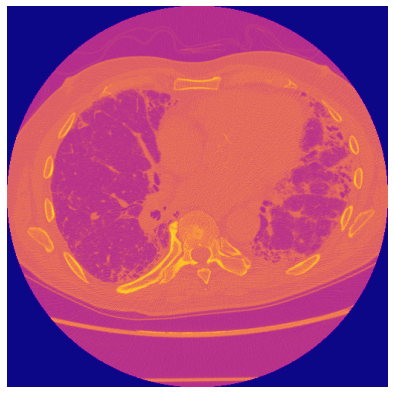

In [19]:
path = "../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/19.dcm"
dataset = pydicom.dcmread(path)

print(bcolors.OKBLUE + "Patient id.......:", dataset.PatientID, "\n" +
      "Modality.........:", dataset.Modality, "\n" +
      "Rows.............:", dataset.Rows, "\n" +
      "Columns..........:", dataset.Columns)

plt.figure(figsize = (7, 7))
plt.imshow(dataset.pixel_array, cmap="plasma")
plt.axis('off');

## 3.3 A breath-in + hold for a Patient

> You can see how the lungs expand image by image.

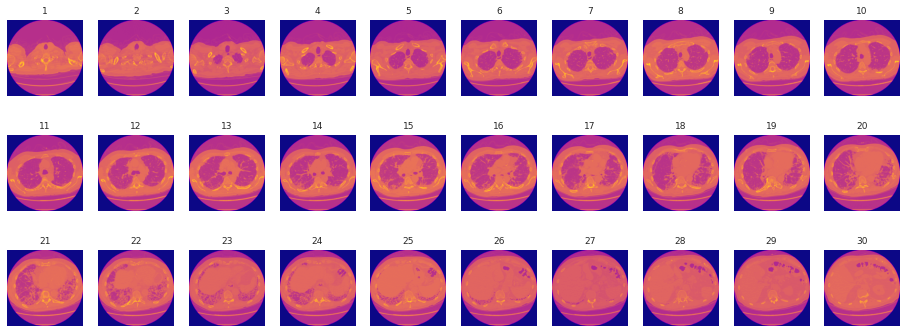

In [20]:
patient_dir = "../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430"
datasets = []

# First Order the files in the dataset
files = []
for dcm in list(os.listdir(patient_dir)):
    files.append(dcm) 
files.sort(key=lambda f: int(re.sub('\D', '', f)))

# Read in the Dataset
for dcm in files:
    path = patient_dir + "/" + dcm
    datasets.append(pydicom.dcmread(path))

# Plot the images
fig=plt.figure(figsize=(16, 6))
columns = 10
rows = 3

for i in range(1, columns*rows +1):
    img = datasets[i-1].pixel_array
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="plasma")
    plt.title(i, fontsize = 9)
    plt.axis('off');

## 3.4 GIF from Images 🌔🌕🌖

> **📌Remember**: Patients have various number of CT scans: the more scans/patient, the more information we have about well ... their lungs. Here we can see that when patients have low number of scans (~ 12) only a quick "inhale" is observed, whereas when we have 80+ scans the details are much more enhanced.

In [21]:
from PIL import Image
from IPython.display import Image as show_gif
import scipy.misc
import matplotlib

In [22]:
def create_gif(number_of_CT = 87):
    """Picks a patient at random and creates a GIF with their CT scans."""
    
    # Select one of the patients
    # patient = "ID00007637202177411956430"
    patient = train[train["CT_number"] == number_of_CT].sample(random_state=1)["Patient"].values[0]
    
    # === READ IN .dcm FILES ===
    patient_dir = "../input/osic-pulmonary-fibrosis-progression/train/" + patient
    datasets = []

    # First Order the files in the dataset
    files = []
    for dcm in list(os.listdir(patient_dir)):
        files.append(dcm) 
    files.sort(key=lambda f: int(re.sub('\D', '', f)))

    # Read in the Dataset from the Patient path
    for dcm in files:
        path = patient_dir + "/" + dcm
        datasets.append(pydicom.dcmread(path))
        
        
    # === SAVE AS .png ===
    # Create directory to save the png files
    if os.path.isdir(f"png_{patient}") == False:
        os.mkdir(f"png_{patient}")

    # Save images to PNG
    for i in range(len(datasets)):
        img = datasets[i].pixel_array
        matplotlib.image.imsave(f'png_{patient}/img_{i}.png', img)
        
        
    # === CREATE GIF ===
    # First Order the files in the dataset (again)
    files = []
    for png in list(os.listdir(f"../working/png_{patient}")):
        files.append(png) 
    files.sort(key=lambda f: int(re.sub('\D', '', f)))

    # Create the frames
    frames = []

    # Create frames
    for file in files:
    #     print("../working/png_images/" + name)
        new_frame = Image.open(f"../working/png_{patient}/" + file)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save(f'gif_{patient}.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=200, loop=0)

### Create and compare GIFs 🌖🌗🌘

*Note: Gifs were exported and changed to .mp4 format so the notebook can load properly. However, the commented line of code works just fine and you can uncomment and run it.*

In [23]:
create_gif(number_of_CT=12)
# create_gif(number_of_CT=30)
# create_gif(number_of_CT=87)

# print("First file len:", len(os.listdir("../working/png_ID00165637202237320314458")), "\n" +
#       "Second file len:", len(os.listdir("../working/png_ID00199637202248141386743")), "\n" +
#       "Third file len:", len(os.listdir("../working/png_ID00340637202287399835821")))

### 12 CT scans GIF:

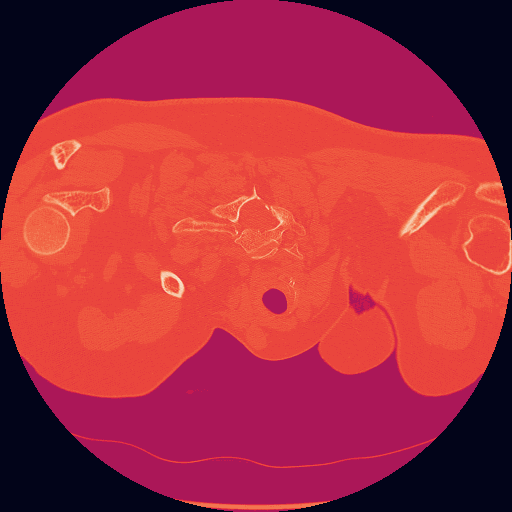

In [24]:
show_gif(filename="./gif_ID00165637202237320314458.gif", format='png', width=400, height=400)

### 30 and 87 CT scans GIF:

In [25]:
# show_gif(filename="./gif_ID00340637202287399835821.gif", format='png', width=400, height=400)
# show_gif(filename="./gif_ID00199637202248141386743.gif", format='png', width=400, height=400)

## 3.5 DICOM Lung Mask🎭

<div class="alert alert-block alert-info">
<b>Reference:</b> <a link="https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/"> DICOM Processing Segmentation Visualization in Python</a>
</div>

**Mask on Lungs Purpose:**
* Segmentation is part of the preprocessing method
* Has the purpose of auto-detecting the boundaries surrounding a volume of interest (our case is the lungs)
* Drawbacks: be sure you don't exclude important parts (like lesions)

In [26]:
# https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Find the average pixel value near the lungs
        # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0


    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

### How does the mask work?

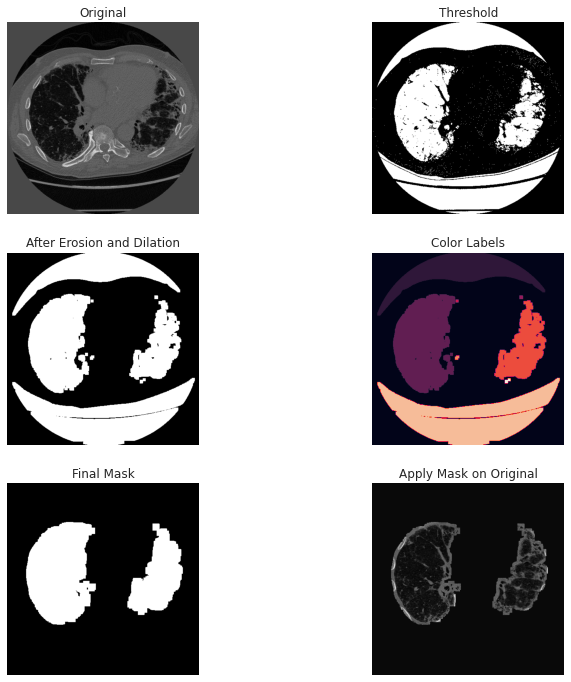

In [27]:
# Select a sample
path = "../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/19.dcm"
dataset = pydicom.dcmread(path)
img = dataset.pixel_array

# Masked image
mask_img = make_lungmask(img, display=True)

### Mask Images for one Patient

> **📌Remember**: Lungs are quite visible, but on images at the beginning and towards the end the lung dissapears completely.

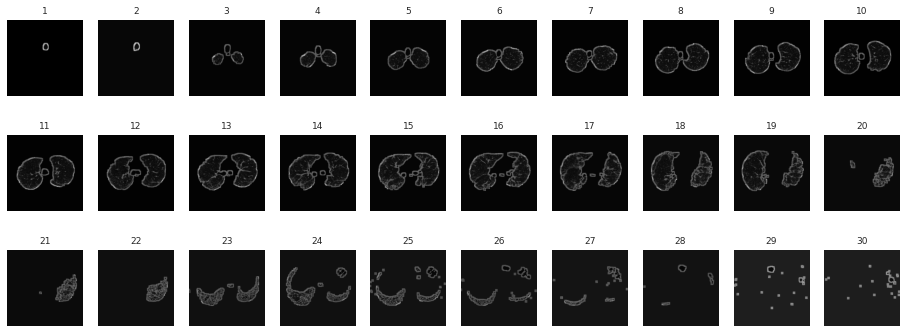

In [28]:
patient_dir = "../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430"
datasets = []

# First Order the files in the dataset
files = []
for dcm in list(os.listdir(patient_dir)):
    files.append(dcm) 
files.sort(key=lambda f: int(re.sub('\D', '', f)))

# Read in the Dataset
for dcm in files:
    path = patient_dir + "/" + dcm
    datasets.append(pydicom.dcmread(path))
    
imgs = []
for data in datasets:
    img = data.pixel_array
    imgs.append(img)
    
    
# Show masks
fig=plt.figure(figsize=(16, 6))
columns = 10
rows = 3

for i in range(1, columns*rows +1):
    img = make_lungmask(datasets[i-1].pixel_array)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
    plt.title(i, fontsize = 9)
    plt.axis('off');

# 4. 🏃‍♂️RAPIDS - crazy fast🏃‍♂️

> In this part we will use [rapids.ai](https://rapids.ai/) to extract and preprocess the *metadata from the dicom files* as well as the *data available in the train.csv*.

In [29]:
# https://www.kaggle.com/cdeotte/rapids

import sys
!cp ../input/rapids/rapids.0.14.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

### Libraries 📚⬇

In [30]:
# Imports
import cudf
import tqdm

## 4.1 Extracting Metadata from DICOM files

> **📌Remember:** the `.get()` function is used overall for .dcm files that don't have all columns available. So, to not skip the entire file, we extract only what's available and fill in the rest with *None*.

*Inspo from [Extract Metadata and Resize Notebook](https://www.kaggle.com/trsekhar123/nb-to-extract-metadata-and-resize-images-train)*

In [31]:
def get_observation_data(path):
    """Get information from the .dcm files.
    path: complete path to the .dcm file"""

    image_data = pydicom.read_file(path)
    
    # Dictionary to store the information from the image
    observation_data = {
        "FileNumber" : path.split("/")[5],
        "Rows" : image_data.get("Rows"),
        "Columns" : image_data.get("Columns"),
        "PatientID" : image_data.get("PatientID"),
        "BodyPartExamined" : image_data.get("BodyPartExamined"),
        "RotationDirection" : image_data.get("RotationDirection"),
        "ConvolutionKernel" : image_data.get("ConvolutionKernel"),
        "PatientPosition" : image_data.get("PatientPosition"),
        "PhotometricInterpretation" : image_data.get("PhotometricInterpretation"),
        "Modality" : image_data.get("Modality"),
        "StudyInstanceUID" : image_data.get("StudyInstanceUID"),
        "PixelPaddingValue" : image_data.get("PixelPaddingValue"),
        "SamplesPerPixel" : image_data.get("SamplesPerPixel"),
        "BitsAllocated" : image_data.get("BitsAllocated"),
        "BitsStored" : image_data.get("BitsStored"),
        "HighBit" : image_data.get("HighBit"),
        "PixelRepresentation" : image_data.get("PixelRepresentation"),
        "RescaleType" : image_data.get("RescaleType"),
    }

    # Integer columns
    int_columns = ["SliceThickness", "KVP", "DistanceSourceToDetector", 
        "DistanceSourceToPatient", "GantryDetectorTilt", "TableHeight", 
        "XRayTubeCurrent", "GeneratorPower", "WindowCenter", "WindowWidth", 
        "SliceLocation", "RescaleIntercept", "RescaleSlope"]
    for k in int_columns:
        observation_data[k] = int(image_data.get(k)) if k in image_data else None

    # String columns
    str_columns = ["ImagePositionPatient", "ImageOrientationPatient", "ImageType", "PixelSpacing"]
    for k in str_columns:
        observation_data[k] = str(image_data.get(k)) if k in image_data else None

    
    return observation_data

### Test the function to see if it works

In [32]:
p = "../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/10.dcm"
example = get_observation_data(p)

# example

In [33]:
# Get full paths for the images
paths = []
for path in train["Path"]:
    for doc in os.listdir(path):
        paths.append(path + "/" + doc)
        
# How many paths?
print("There are {:,} paths in total.".format(len(paths)))

There are 289,826 paths in total.


*Discussion💬 here: [rapids question](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/172373)*

> ❗ **Note**: Code to be revised; maybe make it faster. Also, I'm using `pd.DataFrame()` as `cudf.DataFrame()` is not working properly (it's exracting only the keys of the dict, not the values themselves)

In [34]:
# Create a dictionary with the data
exceptions = 0
dicts = []

for path in tqdm.tqdm(paths):
    # Get info in dict format
    try:
        d = get_observation_data(path)
        dicts.append(d)
    except Exception as e:
        exceptions += 1
        continue

# Convert into a cudf dataframe
# meta_train_data = cudf.DataFrame(data=dicts, columns=example.keys())
meta_train_data = pd.DataFrame(data=dicts, columns=example.keys())

# Export information to a .csv
meta_train_data.to_csv("meta_train.csv", index=False)

100%|██████████| 289826/289826 [16:07<00:00, 299.44it/s]


In [35]:
print("Exceptions: {}".format(exceptions))
meta_train_data.head()

Exceptions: 279


FileNumber  Rows  Columns                  PatientID BodyPartExamined  \
0     29.dcm   512      512  ID00007637202177411956430            Chest   
1     10.dcm   512      512  ID00007637202177411956430            Chest   
2      6.dcm   512      512  ID00007637202177411956430            Chest   
3      3.dcm   512      512  ID00007637202177411956430            Chest   
4     18.dcm   512      512  ID00007637202177411956430            Chest   

  RotationDirection ConvolutionKernel PatientPosition  \
0                CW              BONE             FFS   
1                CW              BONE             FFS   
2                CW              BONE             FFS   
3                CW              BONE             FFS   
4                CW              BONE             FFS   

  PhotometricInterpretation Modality  ... GeneratorPower  WindowCenter  \
0               MONOCHROME2       CT  ...         9600.0          -500   
1               MONOCHROME2       CT  ...         9600.0          -500   
2               MONOCHROME2       CT  ...         9600.0          -500   
3               MONOCHROME2       CT  ...         9600.0          -500   
4               MONOCHROME2       CT  ...         9600.0          -500   

   WindowWidth  SliceLocation  RescaleIntercept  RescaleSlope  \
0        -1500         -349.0             -1024             1   
1        -1500         -159.0             -1024             1   
2        -1500         -119.0             -1024             1   
3        -1500          -89.0             -1024             1   
4        -1500         -239.0             -1024             1   

             ImagePositionPatient  \
0  [-158.700, -153.500, -349.750]   
1  [-158.700, -153.500, -159.750]   
2  [-158.700, -153.500, -119.750]   
3   [-158.700, -153.500, -89.750]   
4  [-158.700, -153.500, -239.750]   

                             ImageOrientationPatient  \
0  [1.000000, 0.000000, 0.000000, 0.000000, 1.000...   
1  [1.000000, 0.000000, 0.000000, 0.000000, 1.000...   
2  [1.000000, 0.000000, 0.000000, 0.000000, 1.000...   
3  [1.000000, 0.000000, 0.000000, 0.000000, 1.000...   
4  [1.000000, 0.000000, 0.000000, 0.000000, 1.000...   

                          ImageType          PixelSpacing  
0  ['ORIGINAL', 'PRIMARY', 'AXIAL']  [0.652344, 0.652344]  
1  ['ORIGINAL', 'PRIMARY', 'AXIAL']  [0.652344, 0.652344]  
2  ['ORIGINAL', 'PRIMARY', 'AXIAL']  [0.652344, 0.652344]  
3  ['ORIGINAL', 'PRIMARY', 'AXIAL']  [0.652344, 0.652344]  
4  ['ORIGINAL', 'PRIMARY', 'AXIAL']  [0.652344, 0.652344]  

[5 rows x 35 columns]

## 4.2 Analyze Metadata

## #1. Missing Values

> **📌Remember:** `PixelPaddingValue` and `Rescale Type` columns are more than 80% empty, so they will be erased. 

---Missing Columns--- 
Pixel Padding Value missing percentage: 0.85 
Rescale Type missing percentage: 0.56 
Dist Source to Detector missing percentage: 0.40 
Dist Source to Patient missing percentage: 0.40 
Gantry Detector Tilt missing percentage: 0.00 
Generator Power missing percentage: 0.34 
Slice Location missing percentage: 0.01 
Img Position Patient missing percentage: 0.01 
Img Orientation Patient missing percentage: 0.01


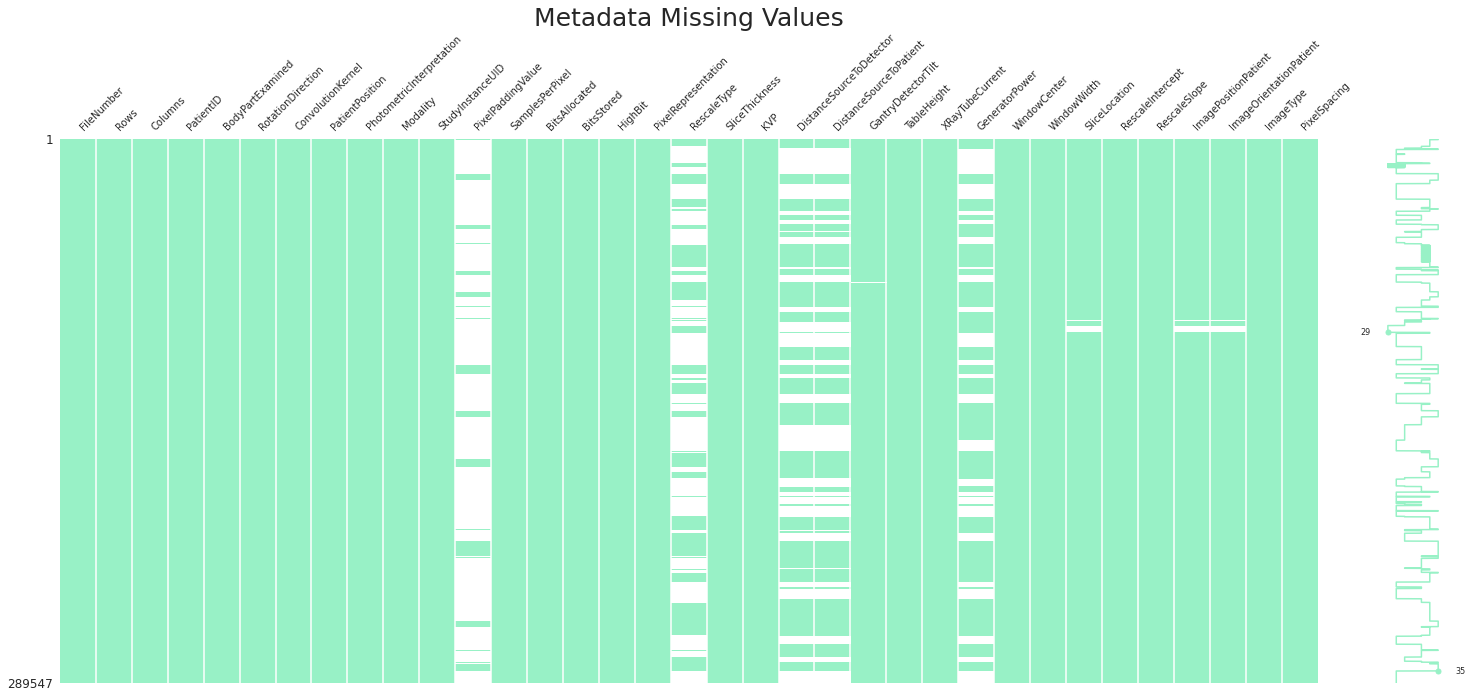

In [36]:
# Inspect the Missing Columns
print("---Missing Columns---", "\n" +
      "Pixel Padding Value missing percentage: {:.2f}".format(meta_train_data["PixelPaddingValue"].isna().sum()/
                                                              len(meta_train_data["PixelPaddingValue"])), "\n" +
      "Rescale Type missing percentage: {:.2f}".format(meta_train_data["RescaleType"].isna().sum()/
                                                       len(meta_train_data["RescaleType"])), "\n" +
      "Dist Source to Detector missing percentage: {:.2f}".format(meta_train_data["DistanceSourceToDetector"].isna().sum()/
                                                       len(meta_train_data["DistanceSourceToDetector"])), "\n" +
      "Dist Source to Patient missing percentage: {:.2f}".format(meta_train_data["DistanceSourceToPatient"].isna().sum()/
                                                       len(meta_train_data["DistanceSourceToPatient"])), "\n" +
      "Gantry Detector Tilt missing percentage: {:.2f}".format(meta_train_data["GantryDetectorTilt"].isna().sum()/
                                                       len(meta_train_data["GantryDetectorTilt"])), "\n" +
      "Generator Power missing percentage: {:.2f}".format(meta_train_data["GeneratorPower"].isna().sum()/
                                                          len(meta_train_data["GeneratorPower"])), "\n" +
      "Slice Location missing percentage: {:.2f}".format(meta_train_data["SliceLocation"].isna().sum()/
                                                       len(meta_train_data["SliceLocation"])), "\n" +
      "Img Position Patient missing percentage: {:.2f}".format(meta_train_data["ImagePositionPatient"].isna().sum()/
                                                       len(meta_train_data["ImagePositionPatient"])), "\n" +
      "Img Orientation Patient missing percentage: {:.2f}".format(meta_train_data["ImageOrientationPatient"].isna().sum()/
                                                       len(meta_train_data["ImageOrientationPatient"])))

# Create figure
ax = msno.matrix(meta_train_data, color=(152/255, 241/255, 198/255), fontsize=10);
plt.title("Metadata Missing Values", fontsize = 25);

*Dropping the 2 columns*

In [37]:
meta_train_data.drop(['PixelPaddingValue', 'RescaleType'], axis=1, inplace=True)

# Export information to a .csv
meta_train_data.to_csv("meta_train.csv", index=False)

> **📌Remember:** Now let's handle the other 7 columns and impute appropriately.

# To Be Continued ...


# References📇
* [What is Pulmonary Fibrosis?](https://www.pulmonaryfibrosis.org/life-with-pf/about-pf)
* [Confidence Clarification](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/166753)
* [What are CT scans capturing?](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/167085)
